# CNN on [Cell images](https://drive.google.com/file/d/1N1gcN8_5dZVlIejoC00QZLSZFhGoSoQb/view)

Study of the [course](https://www.udemy.com/course/practical-ai-with-python-and-reinforcement-learning).

# Working with Custom Images

So far everything we've worked with has been nicely formatted for us already by Keras.

Let's explore what its like to work with a more realistic data set.

## The Data

ORIGINAL DATA SOURCE:

The dataset contains 2 folders - Infected - Uninfected

And a total of 27,558 images.

Acknowledgements
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/

**Note: We will be dealing with real image files, NOT numpy arrays. Which means a large part of this process will be learning how to work with and deal with large groups of image files. This is too much data to fit in memory as a numpy array, so we'll need to feed it into our model in batches. **

### Visualizing the Data


-------
Let's take a closer look at the data.

In [1]:
!unzip /content/drive/MyDrive/ml-dataset/data/cell_images.zip

Streaming output truncated to the last 5000 lines.
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_245.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_251.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_261.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_41.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_54.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_57.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_85.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142730_cell_104.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142730_cell_109.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142730_cell_128.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142730_cell_142.pn

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

os.listdir("/content/cell_images")

['train', 'test']

In [3]:
from matplotlib.image import imread

root_path = "/content/cell_images"
train_path = f"{root_path}/train/"
test_path = f"{root_path}/test/"

In [4]:
print("train_path:", os.listdir(train_path))
print("test_path:", os.listdir(test_path))

train_path: ['parasitized', 'uninfected']
test_path: ['parasitized', 'uninfected']


In [5]:
path_img_cell = os.listdir(train_path + "parasitized")[0]
img_cell = imread(train_path + "parasitized/" + path_img_cell)
img_cell.shape

(160, 97, 3)

In [6]:
def show_imag(idx: int, cell_type: str, path_type="train"):
  path_img_cell = os.listdir(root_path + "/" + path_type + "/" + cell_type)[0]
  img_cell = imread(root_path + "/" + path_type + "/" + cell_type + "/" + path_img_cell)
  plt.title(cell_type)
  plt.axis("off")
  plt.imshow(img_cell)
  plt.show()

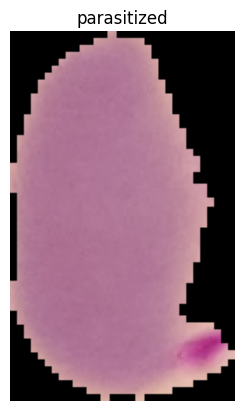

In [7]:
show_imag(0, "parasitized")

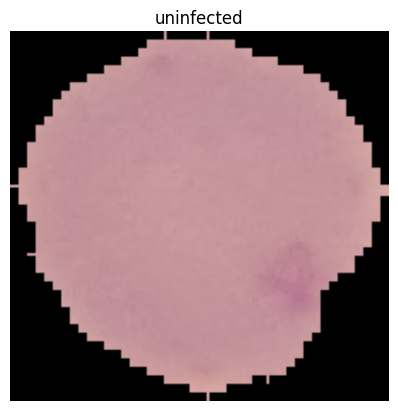

In [8]:
show_imag(0, "uninfected")

In [9]:
for folder_path in os.listdir(train_path):
  print(f"{train_path}{folder_path}:", len(os.listdir(train_path + "/" + folder_path)))

for folder_path in os.listdir(test_path):
  print(f"{test_path}{folder_path}:", len(os.listdir(test_path + "/" + folder_path)))

/content/cell_images/train/parasitized: 12480
/content/cell_images/train/uninfected: 12480
/content/cell_images/test/parasitized: 1300
/content/cell_images/test/uninfected: 1300


In [10]:
dim1 = []
dim2 = []

for path_img in os.listdir(test_path + "/uninfected"):
  img = imread(test_path + "/uninfected/" + path_img)
  d1, d2, colors = img.shape
  dim1.append(d1)
  dim2.append(d2)

## Image with different dimensions (width, height) from each other

In [11]:
dim1[:10]

[106, 136, 124, 139, 154, 130, 118, 151, 142, 139]

In [12]:
dim2[:10]

[100, 121, 118, 148, 151, 133, 118, 121, 115, 139]

We're trying to find visually what's the "ideal" width and height of the image, we can find the mean

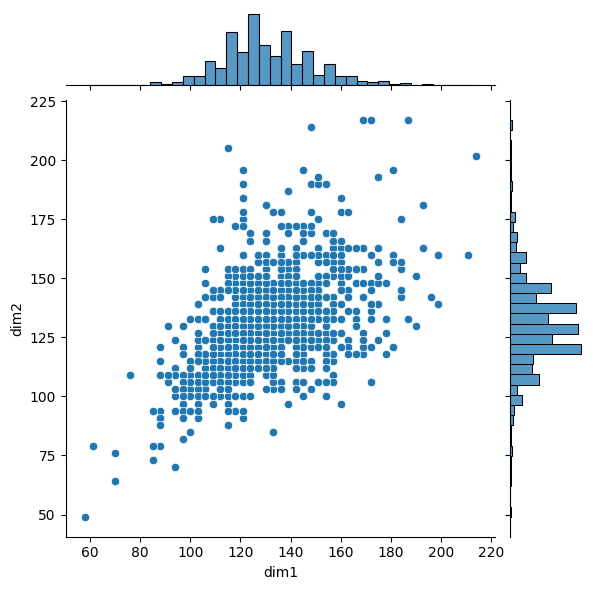

In [13]:
df_dims = pd.DataFrame({"dim1": dim1, "dim2": dim2})
sns.jointplot(data=df_dims, x="dim1", y="dim2")
plt.show()

In [14]:
df_dims["dim1"].mean(), df_dims["dim2"].mean()

(130.92538461538462, 130.75)

In [15]:
# The mean size of image is 130
image_shape = (130, 130, 3)

In [16]:
# The image is normalized? Yes, it's in the range [0, 1]
path_img_cell = os.listdir(train_path + "parasitized")[1]
infected_cell_img = imread(train_path + "parasitized/" + path_img_cell)
infected_cell_img.max()

0.8745098

## Image Generator

Because of the limited dataset, we're using the ImageDataGenerator to generate new images based on the real ones by applying rotation, shifting, zooming, and flipping.

In [17]:
from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

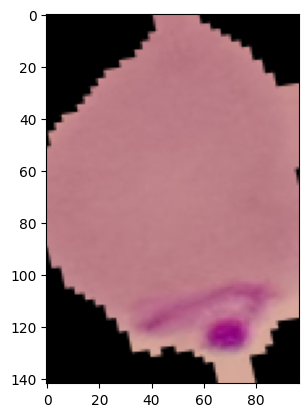

In [18]:
# Here we generated a new one based on the real one
gen_infected_cell = image_gen.random_transform(infected_cell_img)
plt.imshow(gen_infected_cell)
plt.show()

### Generating many manipulated images from a directory

In order to use .flow_from_directory, you must organize the images in sub-directories. This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

**Obs.: This info is from the notebook of the course**



Structure of the folders of this project is respecting the strucuted requested by ImageDataGenerator:

* train_path:
    * parasitized
        * 0.jpg
        * 1.jpg
        * ...
    * uninfected
        * 0.jpg
        * 1.jpg
        * ...
* test_path:
    * parasitized
        * 0.jpg
        * 1.jpg
        * ...
    * uninfected
        * 0.jpg
        * 1.jpg
        * ...

In [19]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [20]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [21]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten

In [22]:
# https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3),
                 input_shape=image_shape, activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3),
                 input_shape=image_shape, activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3),
                 input_shape=image_shape, activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

In [24]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=5)

In [25]:
batch_size = 16
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode="rgb",
                                                batch_size=batch_size,
                                                class_mode="binary")
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode="rgb",
                                               batch_size=batch_size,
                                               class_mode="binary",
                                               shuffle=False)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [26]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [27]:
results = model.fit_generator(train_image_gen, epochs=20,
                              validation_data=test_image_gen,
                              callbacks=[early_stop])

<ipython-input-27-4dc41aa9d178>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_image_gen, epochs=20,


Epoch 1/20
1560/1560 [==============================] - 166s 102ms/step - loss: 1.2683 - accuracy: 0.5475 - val_loss: 0.6809 - val_accuracy: 0.5712
Epoch 2/20
1560/1560 [==============================] - 156s 100ms/step - loss: 0.6808 - accuracy: 0.5713 - val_loss: 0.6717 - val_accuracy: 0.5981
Epoch 3/20
1560/1560 [==============================] - 162s 104ms/step - loss: 0.6764 - accuracy: 0.5873 - val_loss: 0.6766 - val_accuracy: 0.5688
Epoch 4/20
1560/1560 [==============================] - 154s 98ms/step - loss: 0.6733 - accuracy: 0.5903 - val_loss: 0.6683 - val_accuracy: 0.6100
Epoch 5/20
1560/1560 [==============================] - 154s 99ms/step - loss: 0.6789 - accuracy: 0.5908 - val_loss: 0.6726 - val_accuracy: 0.5892
Epoch 6/20
1560/1560 [==============================] - 166s 107ms/step - loss: 0.6722 - accuracy: 0.5966 - val_loss: 0.6781 - val_accuracy: 0.5869
Epoch 7/20
1560/1560 [==============================] - 154s 98ms/step - loss: 0.6709 - accuracy: 0.5990 - val_los

In [28]:
model.metrics_names

['loss', 'accuracy']

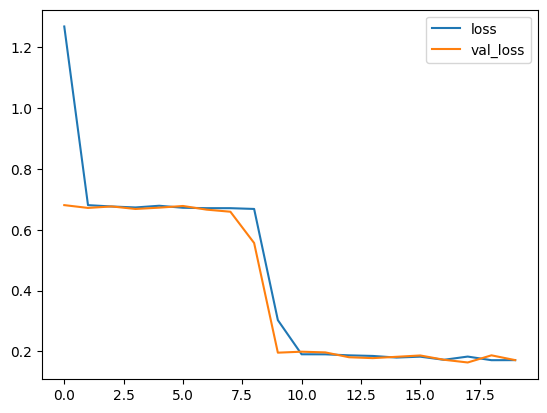

In [29]:
df_loss = pd.DataFrame(model.history.history)
df_loss[["loss", "val_loss"]].plot()
plt.show()

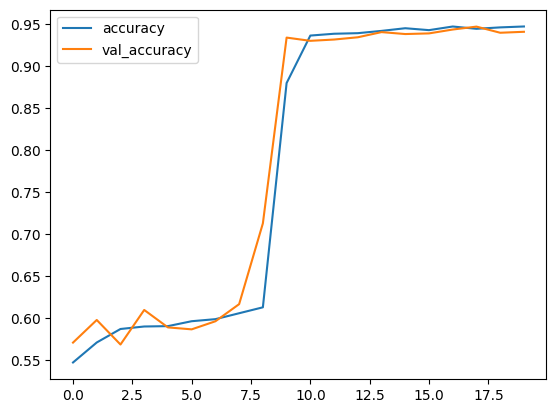

In [30]:
df_loss[["accuracy", "val_accuracy"]].plot()
plt.show()

In [31]:
from keras.models import load_model

# model = load_model("/content/malaria_detector.h5")
model.save("malaria_detector.h5")
model.evaluate_generator(test_image_gen)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
<ipython-input-31-6293436b07bf>:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_image_gen)


[0.17662684619426727, 0.9411538243293762]

### If this code is used in real life, you would need to increase the threshold, to for example, 0.8, you must choose between precision and recall (it's a trade-off). In this case it's better no have more false positive (the model classifies as infected but it's not infected) than have false negative (it's infected, but the model classified as not infected).

In [34]:
threshold = 0.5
pred = model.predict_generator(test_image_gen)
pred = pred > threshold
pred

<ipython-input-34-8c9d50c7d503>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_image_gen)


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_image_gen.classes, pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1300
           1       0.94      0.94      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



In [36]:
print(confusion_matrix(test_image_gen.classes, pred))

[[1222   78]
 [  73 1227]]


## Simulate production model call for new samples

The code below is simulation the case where the doctor passes a new image to the model

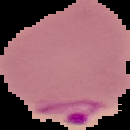

In [38]:
from keras.preprocessing import image

my_image = image.load_img(train_path + "parasitized/" + path_img_cell, target_size=image_shape)
my_image

In [40]:
my_image_arr = image.img_to_array(my_image)
my_image_arr

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [41]:
my_image_arr.shape

(130, 130, 3)

In [42]:
# The model expect batches, even it's passed just one image
# from (130, 130, 3) to (1, 130, 130, 3)
my_image_arr = np.expand_dims(my_image_arr, axis=0)
my_image_arr.shape

(1, 130, 130, 3)

### The model classified the image correctly

In [45]:
prediction = (model.predict(my_image_arr) > 0.5).astype("int32")
prediction

1/1 [==============================] - 0s 29ms/step


array([[0]], dtype=int32)

In [46]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}